# Context 

Model selection and final forecasting

- Build a DataFrame containing the last five years of historical data for both training and evaluation.
- Perform model selection to identify the best-performing approach.
- Generate the final out‐of‐sample forecast using the selected model.

# Import

In [0]:
%pip install prophet

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import requests
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.types import StructType, StructField, DateType, DoubleType
from pyspark.sql.functions import (
    col, to_date, lag, avg, stddev, log, when, current_date,
    date_sub, add_months, expr, row_number, dayofweek, lit,
    pandas_udf, PandasUDFType
)
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator


In [0]:
symbol =  "AAPL"
api_key = "UDEJQ3FLFIY9BVVT"

In [0]:
spark = SparkSession.builder.appName("AAPL_Prediction").getOrCreate()

From the dataset we decided to keep only the last 5 years just for test purposes

In [0]:
def get_alpha_vantage_data(symbol, key):
    function = 'TIME_SERIES_DAILY'
    output_size = 'full'
    url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize={output_size}&apikey={key}'

    r = requests.get(url)
    data = r.json()

    if 'Time Series (Daily)' in data:
        df = pd.DataFrame(data['Time Series (Daily)']).T
        df.index = pd.to_datetime(df.index)
        df.sort_index(inplace=True)
        df.columns = [col.split('. ')[1] for col in df.columns]
        df = df.apply(pd.to_numeric)
        df = df[df.index >= datetime.now() - timedelta(days=365*20)]

        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Date'}, inplace=True)
        return spark.createDataFrame(df)
    else:
        raise Exception("Alpha Vantage API Error")

# Models Selection


- in order to test the models we decided only to use a 5 year window 
- For all the model we are using a 30 days test window, this does not mean that the models will make a prediction for each day as the weekends are not taken into our data

In [0]:
spark_df = get_alpha_vantage_data(symbol, api_key)

original_df = spark_df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
num_rows = original_df.count()
num_cols = len(original_df.columns)
print(num_rows, num_cols)
original_df.printSchema()

# take only the last 5 years to reduce the amount of data (just for testing)
cutt_point = -60
cutoff = add_months(current_date(), cutt_point)
df_cutt = original_df.filter(col("date") >= cutoff)


df_cutt = df_cutt.cache()
print(f"Filtered (last 5y): {df_cutt.count()} rows")
df_cutt.show(5, truncate=False)

ts_df = df_cutt

5028 6
root
 |-- date: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: long (nullable = true)

Filtered (last 5y): 1256 rows
+----------+------+------+------+------+--------+
|date      |open  |high  |low   |close |volume  |
+----------+------+------+------+------+--------+
|2020-05-18|313.17|316.5 |310.32|314.96|33843125|
|2020-05-19|315.03|318.52|313.01|313.14|25432385|
|2020-05-20|316.68|319.52|316.52|319.23|27876215|
|2020-05-21|318.66|320.89|315.87|316.85|25672211|
|2020-05-22|315.77|319.23|315.35|318.89|20450754|
+----------+------+------+------+------+--------+
only showing top 5 rows



In [0]:
# create dates for that will be used for testing 
all_dates = [r.date for r in ts_df.select("date").distinct().orderBy("date").collect()]
test_dates = all_dates[-30:]
ts_df = ts_df.select("date", "close")

## Auxilarry Functions 

we decidd to create some feature but we decided to use only features that would be availble at the time of the prediction
- because we are only predicting "close" we decided not to use the coulmns "open" and "volume" because although we have the data for in order to test our algorithms the data won't be available for actual prediction

In [0]:
def make_features(df):
    w = Window.orderBy("date")
    w_roll5 = Window.orderBy("date").rowsBetween(-5, -1)
    w_roll30 = Window.orderBy("date").rowsBetween(-30, -1)
    return (
        df
        .withColumn("close_lag1",lag("close", 1).over(w))
        .withColumn("close_lag2",lag("close", 2).over(w))
        .withColumn("close_lag3",lag("close", 3).over(w))
        .withColumn("close_lag4",lag("close", 4).over(w))
        .withColumn("close_lag5",lag("close", 5).over(w))
        .withColumn("ma5",avg("close").over(w_roll5))
        .withColumn("ma30",avg("close").over(w_roll30))
        .withColumn("dow",dayofweek("date"))
        .na.drop()
    )

## Model using GBTR

we first create:
- the feature in order to see how would our model me fitted only on train data 
- a set of dates that would be used for testing 
- a vector assemble that would be used in the pipeline

In [0]:
# create a vector for the feature that are going to be used for this model
assembler = VectorAssembler(
    inputCols=["close_lag1","close_lag2","close_lag3","close_lag4","close_lag4","close_lag5","ma5","ma30","dow"],
    outputCol="features"
)
gbt = GBTRegressor(labelCol="close", featuresCol="features", maxIter=50)


### Model Run

we first run the model on the overall train_data to see how it fits

Train RMSE = 10.1812
Train Relative RMSE  = 0.0563


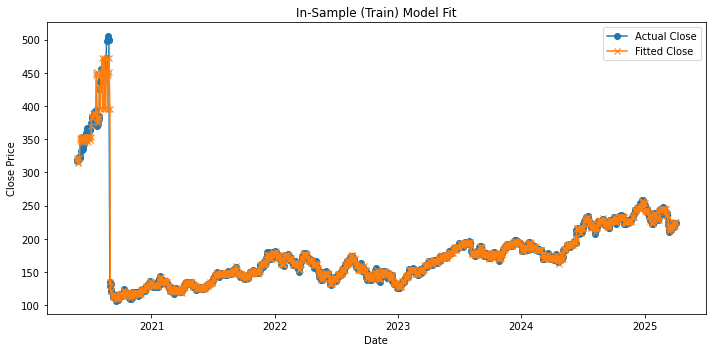

In [0]:
feat_df = make_features(ts_df)
train_feat_df = feat_df.filter(~col("date").isin(test_dates))
train_vec = assembler.transform(train_feat_df)
model = gbt.fit(train_vec)

preds_train = (
    model
      .transform(train_vec)
      .select(
          col("date"),
          col("prediction"),
          col("close").alias("actual")
      )
)

evaluator = RegressionEvaluator(
    labelCol="actual",
    predictionCol="prediction",
    metricName="rmse"
)
train_rmse = evaluator.evaluate(preds_train)
mean_actual = preds_train.select(avg("actual")).first()[0]
train_rrmse = train_rmse / mean_actual

print(f"Train RMSE = {train_rmse:.4f}")
print(f"Train Relative RMSE  = {train_rrmse:.4f}")

train_pdf = preds_train.toPandas()
train_pdf["date"] = pd.to_datetime(train_pdf["date"])

plt.figure(figsize=(10,5))
plt.plot(train_pdf["date"], train_pdf["actual"],     marker='o', label="Actual Close")
plt.plot(train_pdf["date"], train_pdf["prediction"], marker='x', label="Fitted Close")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("In-Sample (Train) Model Fit")
plt.legend()
plt.tight_layout()
plt.show()

In our evaluation we use a **rolling, one-day-ahead** forecasting strategy:

1. **Train on historical data up to the forecast date**  
   At each step, we fit the model on all available data **before** the day we want to predict. This mimics how you would train in production—only past information is ever used.

2. **Predict the next day’s close price**  
   We generate a single forecast for “tomorrow” (the next trading day) using that freshly trained model.

3. **Feed the prediction back in**  
   Instead of using the true close for the next step (which would leak future information), we inject our own forecast into the historical series. Those forecasts then become part of the training data for the following day’s model fit.

This procedure guarantees that **no future actual prices** are ever used when making each prediction—exactly as would occur in a real-world deployment. It also means we can only compute performance metrics (RMSE, RRMSE, etc.) **once** the true values are eventually observed (e.g. end-of-day actual closes).

In [0]:
history = ts_df.filter(~col("date").isin(test_dates))
results = []

# for everyday that we want to predict
for d in test_dates:
    # Create the features to make the prediction
    hist_feat = make_features(history)

    train_vec = assembler.transform(hist_feat.filter(col("date") < d))
    test_vec  = assembler.transform(hist_feat.filter(col("date") == d))

    model = gbt.fit(train_vec)
    pred  = model.transform(test_vec).select("prediction").first()[0]

    # grab the true actual from your original df for error‐tracking
    actual = ts_df.filter(col("date") == d).select("close").first()[0]

    results.append((d, float(pred), float(actual)))

    #append only the prediction to your history 
    new_row = spark.createDataFrame([Row(date=d, close=pred)])
    history = history.union(new_row)

    print(f"iteration done for {d}")

evaluator = RegressionEvaluator(
    labelCol="actual",
    predictionCol="predicted",
    metricName="rmse"
)
# create a spark dataframe from the result and calculate the RMSE using it and RRMSE
result_df = spark.createDataFrame(results, ["date", "predicted", "actual"])
rmse = evaluator.evaluate(result_df)
mean_actual = result_df.select(avg("actual")).first()[0]
rel_rmse = rmse / mean_actual

print(f"Test RMSE = {rmse:.4f}")
print(f"Test Relative RMSE = {rel_rmse:.4f})")

# plot the results
pdf = result_df.toPandas()
pdf["date"] = pd.to_datetime(pdf["date"])

plt.figure(figsize=(10,5))
plt.plot(pdf["date"], pdf["actual"],    marker='o', label="Actual Close")
plt.plot(pdf["date"], pdf["predicted"], marker='x', label="Predicted Close")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("1-Week Rolling-Origin Forecast vs. Actual")
plt.legend()
plt.tight_layout()
plt.show()

## Model using Prophet (pandas UDFs)




We use the same workflow as before but train Prophet on the target series alone.  
Since Prophet isn’t built into Spark, we leverage a pandas UDF to fit and predict:

- **Fit** the model on the training set and generate out-of-sample forecasts to evaluate performance.
- **Note:** We attempted a rolling-window approach to include our engineered features, but couldn’t avoid leakage—feature calculations were unintentionally using future actuals. To keep the evaluation clean, we focus here on univariate forecasting with Prophet.



/databricks/spark/python/pyspark/sql/pandas/group_ops.py:100: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


train RMSE            = 30.6320
train Relative RMSE   = 0.1688


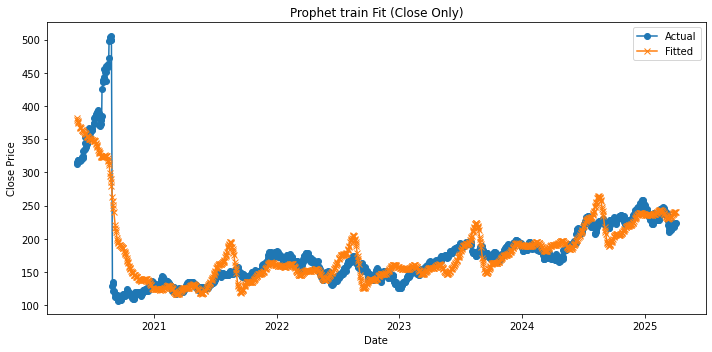

In [0]:
schema_train_ = StructType([
    StructField("date",       DateType()),
    StructField("prediction", DoubleType()),
    StructField("actual",     DoubleType())
])

# pandas UDF: fit Prophet on full training set, predict on that same set
@pandas_udf(schema_train_, PandasUDFType.GROUPED_MAP)
def prophet_train_ample(pdf: pd.DataFrame) -> pd.DataFrame:
    pdf = pdf.sort_values("date")
    pdf["ds"] = pd.to_datetime(pdf["date"])
    pdf["y"]  = pdf["close"]
    
    m = Prophet()
    m.fit(pdf[["ds","y"]])
    
    # predict in‐sample
    fc = m.predict(pdf[["ds"]])  # returns ds, yhat, etc.
    return pd.DataFrame({
        "date":       fc["ds"].dt.date,
        "prediction": fc["yhat"],
        "actual":     pdf["y"].values
    })

# Apply UDF to all rows *except* the test dates
train_df = ts_df.filter(~col("date").isin(test_dates)).withColumn("grp", lit(1))
train_preds = train_df.groupBy("grp").apply(prophet_train_ample).drop("grp")

 # calculate the errors
evaluator = RegressionEvaluator(
    labelCol="actual",
    predictionCol="prediction",
    metricName="rmse"
)
train_rmse     = evaluator.evaluate(train_preds)
mean_train_act = train_preds.select(avg("actual")).first()[0]
train_rrmse    = train_rmse / mean_train_act

print(f"train RMSE            = {train_rmse:.4f}")
print(f"train Relative RMSE   = {train_rrmse:.4f}")

pdf_train_ = train_preds.toPandas()
pdf_train_["date"] = pd.to_datetime(pdf_train_["date"])

plt.figure(figsize=(10,5))
plt.plot(pdf_train_["date"], pdf_train_["actual"],    marker='o', label="Actual")
plt.plot(pdf_train_["date"], pdf_train_["prediction"],marker='x', label="Fitted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Prophet train Fit (Close Only)")
plt.legend()
plt.tight_layout()
plt.show()

We make the prediction on our test set in order to evaluate how our model would perform in "real-life" seneario

/databricks/spark/python/pyspark/sql/pandas/group_ops.py:100: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


Direct RMSE = 43.2811
Direct Relative RMSE = 0.2152


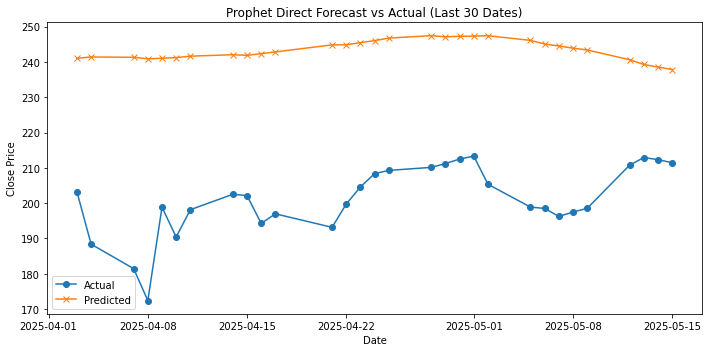

In [0]:
# define output schema
schema_out = StructType([
    StructField("date",       DateType()),
    StructField("prediction", DoubleType()),
    StructField("actual",     DoubleType())
])

# pandas‐UDF that uses test_dates for splitting
@pandas_udf(schema_out, PandasUDFType.GROUPED_MAP)
def prophet_direct(pdf):
    pdf = pdf.sort_values("date")
    pdf["ds"] = pd.to_datetime(pdf["date"])
    
    # split by membership in test_dates
    train = pdf.loc[~pdf["ds"].dt.date.isin(test_dates)]
    test  = pdf.loc[ pdf["ds"].dt.date.isin(test_dates)]
    
    # fit only using close as a predictor and targer
    m = Prophet()
    m.fit(pd.DataFrame({
        "ds": train["ds"],
        "y":  train["close"]
    }))
    
    # predict only on the test window
    future = pd.DataFrame({"ds": test["ds"]})
    fc = m.predict(future)
    
    return pd.DataFrame({
        "date":       fc["ds"].dt.date,
        "prediction": fc["yhat"],
        "actual":     test["close"].values
    })

# 4) Apply the UDF in Spark
roll_df      = ts_df.withColumn("grp", lit(1))
direct_preds = roll_df.groupBy("grp") \
                     .apply(prophet_direct) \
                     .drop("grp")

evaluator   = RegressionEvaluator(
    labelCol="actual",
    predictionCol="prediction",
    metricName="rmse"
)
rmse_spark   = evaluator.evaluate(direct_preds)
mean_act     = direct_preds.select(avg("actual")).first()[0]
rrmse_spark  = rmse_spark / mean_act

print(f"Direct RMSE = {rmse_spark:.4f}")
print(f"Direct Relative RMSE = {rrmse_spark:.4f}")

# change daraframe to pandas for plotting
pdf_direct = direct_preds.toPandas()
pdf_direct["date"] = pd.to_datetime(pdf_direct["date"])
plt.figure(figsize=(10,5))
plt.plot(pdf_direct["date"], pdf_direct["actual"],    marker='o', label="Actual")
plt.plot(pdf_direct["date"], pdf_direct["prediction"],marker='x', label="Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Prophet Direct Forecast vs Actual (Last 30 Dates)")
plt.legend()
plt.tight_layout()
plt.show()


## Model using Arima (pandas UDFs)

In [0]:
%pip install tensorflow

java.util.concurrent.TimeoutException: Futures timed out after [80 seconds]
	at scala.concurrent.impl.Promise$DefaultPromise.ready(Promise.scala:259)
	at scala.concurrent.impl.Promise$DefaultPromise.result(Promise.scala:263)
	at scala.concurrent.Await$.$anonfun$result$1(package.scala:223)
	at scala.concurrent.BlockContext$DefaultBlockContext$.blockOn(BlockContext.scala:57)
	at scala.concurrent.Await$.result(package.scala:146)
	at com.databricks.backend.daemon.driver.JupyterKernelListener$RequestStatus.waitForReply(JupyterKernelListener.scala:206)
	at com.databricks.backend.daemon.driver.JupyterKernelListener.start(JupyterKernelListener.scala:687)
	at com.databricks.backend.daemon.driver.JupyterDriverLocal.$anonfun$startPython$1(JupyterDriverLocal.scala:764)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.util.Try$.apply(Try.scala:213)
	at com.databricks.backend.daemon.driver.JupyterDriverLocal.com$databricks$backend$daemon$driver$JupyterDriverLocal$$withRetry(JupyterDriverLocal.scala:707)
	at com.databricks.backend.daemon.driver.JupyterDriverLocal$$anonfun$com$databricks$backend$daemon$driver$JupyterDriverLocal$$withRetry$1.applyOrElse(JupyterDriverLocal.scala:710)
	at com.databricks.backend.daemon.driver.JupyterDriverLocal$$anonfun$com$databricks$backend$daemon$driver$JupyterDriverLocal$$withRetry$1.applyOrElse(JupyterDriverLocal.scala:707)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at scala.util.Failure.recover(Try.scala:234)
	at com.databricks.backend.daemon.driver.JupyterDriverLocal.com$databricks$backend$daemon$driver$JupyterDriverLocal$$withRetry(JupyterDriverLocal.scala:707)
	at com.databricks.backend.daemon.driver.JupyterDriverLocal.startPython(JupyterDriverLocal.scala:724)
	at com.databricks.backend.daemon.driver.PythonDriverLocalBase.$anonfun$restartPythonProcess$2(PythonDriverLocalBase.scala:628)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:560)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:657)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:678)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:414)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:158)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:412)
	at com.databricks.logging.UsageLogging.withAttributionContext$(UsageLogging.scala:409)
	at com.databricks.backend.daemon.driver.DriverLocal.withAttributionContext(DriverLocal.scala:77)
	at com.databricks.logging.UsageLogging.withAttributionTags(UsageLogging.scala:457)
	at com.databricks.logging.UsageLogging.withAttributionTags$(UsageLogging.scala:442)
	at com.databricks.backend.daemon.driver.DriverLocal.withAttributionTags(DriverLocal.scala:77)
	at com.databricks.logging.UsageLogging.recordOperationWithResultTags(UsageLogging.scala:652)
	at com.databricks.logging.UsageLogging.recordOperationWithResultTags$(UsageLogging.scala:569)
	at com.databricks.backend.daemon.driver.DriverLocal.recordOperationWithResultTags(DriverLocal.scala:77)
	at com.databricks.logging.UsageLogging.recordOperation(UsageLogging.scala:560)
	at com.databricks.logging.UsageLogging.recordOperation$(UsageLogging.scala:528)
	at com.databricks.backend.daemon.driver.DriverLocal.recordOperation(DriverLocal.scala:77)
	at com.databricks.backend.daemon.driver.PythonDriverLocalBase.restartPythonProcess(PythonDriverLocalBase.scala:622)
	at com.databricks.backend.daemon.driver.JupyterDriverLocal.executePython(JupyterDriverLocal.scala:701)
	at com.databricks.backend.daemon.driver.JupyterDriverLocal.repl(JupyterDriverLocal.scala:574)
	at com.databricks.backend.daemon.driver.DriverLocal.$anonfun$e

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1) Pull your Spark DataFrame into pandas
pdf = ts_df.select("date", "close").toPandas()
pdf["date"] = pd.to_datetime(pdf["date"])
pdf = pdf.sort_values("date")

# 2) Define the test window as the last 30 distinct dates
# all_dates = pdf["date"].dt.date.unique()
# test_dates = all_dates[-30:]
train_pdf = pdf[~pdf["date"].dt.date.isin(test_dates)].reset_index(drop=True)
test_pdf  = pdf[ pdf["date"].dt.date.isin(test_dates)].reset_index(drop=True)

# 3) Scale the training series
scaler = MinMaxScaler()
train_vals = train_pdf["close"].values.reshape(-1,1)
scaled_train = scaler.fit_transform(train_vals).flatten()

# 4) Build sliding‐window sequences for LSTM
def create_sequences(series: np.ndarray, window_size: int):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i : i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

window_size = 10
X_train, y_train = create_sequences(scaled_train, window_size)
X_train = X_train.reshape((X_train.shape[0], window_size, 1))

# 5) Define and train the LSTM
model = Sequential([
    LSTM(50, input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# 6) Produce one‐step‐ahead forecasts over the 30‐day test window
preds_scaled = []
window = list(scaled_train[-window_size:])
for _ in range(len(test_pdf)):
    x_input = np.array(window[-window_size:]).reshape(1, window_size, 1)
    yhat   = model.predict(x_input, verbose=0)[0,0]
    preds_scaled.append(yhat)
    window.append(yhat)

# invert scaling
preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten()

# 7) Assemble results
results = pd.DataFrame({
    "date":       test_pdf["date"].dt.date,
    "prediction": preds,
    "actual":     test_pdf["close"].values
})

# 8) Compute RMSE and relative RMSE
rmse  = np.sqrt(mean_squared_error(results["actual"], results["prediction"]))
rrmse = rmse / results["actual"].mean()
print(f"LSTM Direct RMSE            = {rmse:.4f}")
print(f"LSTM Direct Relative RMSE   = {rrmse:.4f}")

# 9) Plot actual vs. predicted
plt.figure(figsize=(10,5))
plt.plot(results["date"], results["actual"],    marker='o', label="Actual")
plt.plot(results["date"], results["prediction"],marker='x', label="Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("LSTM Direct Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()



java.lang.IllegalStateException: jupyter client is not available because the python kernel is not defined. The kernel may be restarting or the repl may have been shut down.
	at com.databricks.backend.daemon.driver.JupyterDriverLocal.$anonfun$getJupyterKernelListener$1(JupyterDriverLocal.scala:344)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.backend.daemon.driver.JupyterDriverLocal.com$databricks$backend$daemon$driver$JupyterDriverLocal$$getJupyterKernelListener(JupyterDriverLocal.scala:343)
	at com.databricks.backend.daemon.driver.JupyterDriverLocal.executePython(JupyterDriverLocal.scala:612)
	at com.databricks.backend.daemon.driver.JupyterDriverLocal.repl(JupyterDriverLocal.scala:574)
	at com.databricks.backend.daemon.driver.DriverLocal.$anonfun$execute$27(DriverLocal.scala:929)
	at com.databricks.unity.EmptyHandle$.runWith(UCSHandle.scala:125)
	at com.databricks.backend.daemon.driver.DriverLocal.$anonfun$execute$24(DriverLocal.scala:920)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:414)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:158)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:412)
	at com.databricks.logging.UsageLogging.withAttributionContext$(UsageLogging.scala:409)
	at com.databricks.backend.daemon.driver.DriverLocal.withAttributionContext(DriverLocal.scala:77)
	at com.databricks.logging.UsageLogging.withAttributionTags(UsageLogging.scala:457)
	at com.databricks.logging.UsageLogging.withAttributionTags$(UsageLogging.scala:442)
	at com.databricks.backend.daemon.driver.DriverLocal.withAttributionTags(DriverLocal.scala:77)
	at com.databricks.backend.daemon.driver.DriverLocal.execute(DriverLocal.scala:889)
	at com.databricks.backend.daemon.driver.DriverWrapper.$anonfun$tryExecutingCommand$2(DriverWrapper.scala:719)
	at scala.util.Try$.apply(Try.scala:213)
	at com.databricks.backend.daemon.driver.DriverWrapper.$anonfun$tryExecutingCommand$1(DriverWrapper.scala:711)
	at com.databricks.backend.daemon.driver.DriverWrapper.tryExecutingCommand(DriverWrapper.scala:739)
	at com.databricks.backend.daemon.driver.DriverWrapper.executeCommandAndGetError(DriverWrapper.scala:628)
	at com.databricks.backend.daemon.driver.DriverWrapper.executeCommand(DriverWrapper.scala:663)
	at com.databricks.backend.daemon.driver.DriverWrapper.runInnerLoop(DriverWrapper.scala:499)
	at com.databricks.backend.daemon.driver.DriverWrapper.runInner(DriverWrapper.scala:438)
	at com.databricks.backend.daemon.driver.DriverWrapper.run(DriverWrapper.scala:262)
	at java.lang.Thread.run(Thread.java:750)

# Actual Prediction

In [0]:
# 1) Fit on the entire history once
full_feat  = make_features(ts_df)
full_vec   = assembler.transform(full_feat)
model_full = gbt.fit(full_vec)

# 2) Pull the last 30 closes into a Python list (most recent first)
last30 = (
    ts_df
      .orderBy(col("date").desc())
      .limit(30)
      .select("close")
      .rdd.flatMap(lambda r: r)
      .collect()
)

# 3) Find your “starting” date
all_dates = sorted(r.date for r in ts_df.select("date").distinct().collect())
next_date = all_dates[-1] + datetime.timedelta(days=1)

preds  = []
closes = last30.copy()
count  = 0

# 4) Roll forward until you've made 30 business‐day forecasts
while count < 30:
    # skip weekends
    if next_date.weekday() >= 5:   # 5=Saturday, 6=Sunday
        next_date += datetime.timedelta(days=1)
        continue

    # compute lags & moving averages
    lags = closes[:5]
    ma5  = sum(lags) / 5
    ma30 = sum(closes) / len(closes)
    dow  = (next_date.weekday() + 1) % 7 + 1  # Spark dayofweek

    # build the single‐row feature
    future_row = Row(
        date       = next_date,
        close_lag1 = float(lags[0]),
        close_lag2 = float(lags[1]),
        close_lag3 = float(lags[2]),
        close_lag4 = float(lags[3]),
        close_lag5 = float(lags[4]),
        ma5        = float(ma5),
        ma30       = float(ma30),
        dow        = int(dow)
    )
    future_df  = spark.createDataFrame([future_row])
    future_vec = assembler.transform(future_df)

    # predict and record
    pred = model_full.transform(future_vec).select("prediction").first()[0]
    preds.append((next_date, float(pred)))

    # feed the prediction back into your “closes” list
    closes.insert(0, pred)
    if len(closes) > 30:
        closes.pop()

    # advance
    next_date += datetime.timedelta(days=1)
    count     += 1

# 5) Wrap up
pred_df = spark.createDataFrame(preds, ["date","forecast"])
pred_df.show(30)


+----------+------------------+
|      date|          forecast|
+----------+------------------+
|2025-05-14|214.17595697963802|
|2025-05-15| 213.9632341890576|
|2025-05-16|212.74863638742514|
|2025-05-17| 214.8399055583746|
|2025-05-18| 216.6580926099726|
|2025-05-19| 216.6580926099726|
|2025-05-20|217.00403671482277|
|2025-05-21|216.68126333385194|
|2025-05-22|215.01751205294866|
|2025-05-23| 214.8399055583746|
|2025-05-24| 214.8399055583746|
|2025-05-25| 216.6580926099726|
|2025-05-26| 216.6580926099726|
|2025-05-27|217.00403671482277|
|2025-05-28|216.68126333385194|
|2025-05-29|215.01751205294866|
|2025-05-30| 214.8399055583746|
|2025-05-31| 214.8399055583746|
|2025-06-01| 216.6580926099726|
|2025-06-02| 216.6580926099726|
|2025-06-03|217.00403671482277|
|2025-06-04|216.68126333385194|
|2025-06-05|215.01751205294866|
|2025-06-06| 214.8399055583746|
|2025-06-07| 214.8399055583746|
|2025-06-08| 216.6580926099726|
|2025-06-09| 216.6580926099726|
|2025-06-10|217.00403671482277|
|2025-06